In [1]:
import pandas_profiling

import scipy as ss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import random

import skorch
from skorch import NeuralNetRegressor

import torch.nn.functional as F

import torch.nn as nn
import torch

from scipy import stats

from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

from math import ceil

from fast_ml.model_development import train_valid_test_split

In [2]:
random.seed(67)
np.random.seed(67)
torch.manual_seed(67)
torch.use_deterministic_algorithms(True)

- `Temperature (K)` —  температура на поверхности звезды в Кельвинах
- `Luminosity(L/Lo)` — светимость звезды относительно Солнца
- `Radius(R/Ro)` — радиус звезды относительно радиуса Солнца
- `Absolute magnitude(Mv)` — физическая величина, характеризующая блеск звезды
- `Star type` — Тип звезды(0 - коричневый карлик, 1 - красный карлик, 2 - белый карлик, 3 - звездны главной последовательности, 4 - сверхгигант, 5 - гипергигант)
- `Star color` — цвет звезды, который определяют на основе спектрального анализа

## Загрузка данных

In [3]:
df = pd.read_csv('C:/Users/nikit/Yandex/projects/neuralnet/data/class.csv', index_col=[0])
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [4]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Слишком сильно разбросаны данные, распределение ненормальное. Большое стандартное отклонение.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


Нужно проверить точно светимость звезды относительно Солнца, т.к. там есть очень много значений, которые близки к 0. А также радиус. Имеются признаки, которые имеют зависимость с таргетом, такие как **Star type** и **Absolute magnitude(Mv)**, а также признаки, которые имеют зависимость между собой, что не есть хорошо и нужно будет что-то придумать, чтобы избавиться от этого.

## Предобработка и анализ данных

In [7]:
df.columns = ['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
              'Absolute_magnitude(Mv)', 'Star_type', 'Star_color']

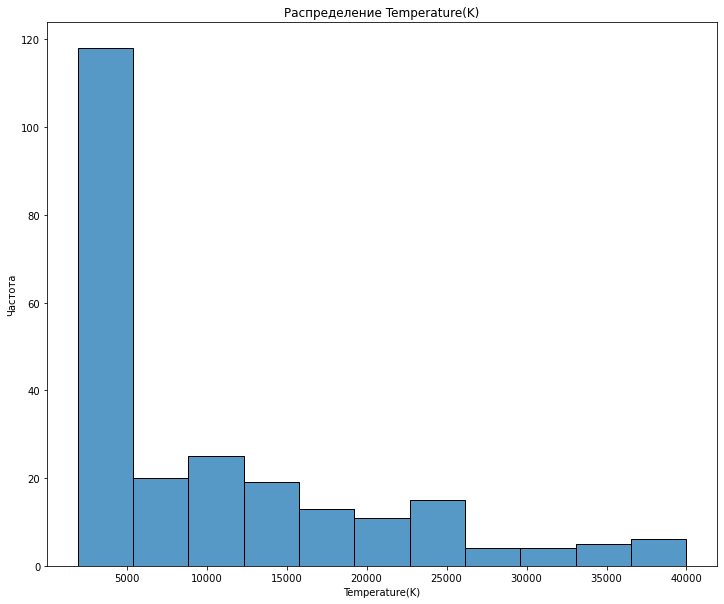

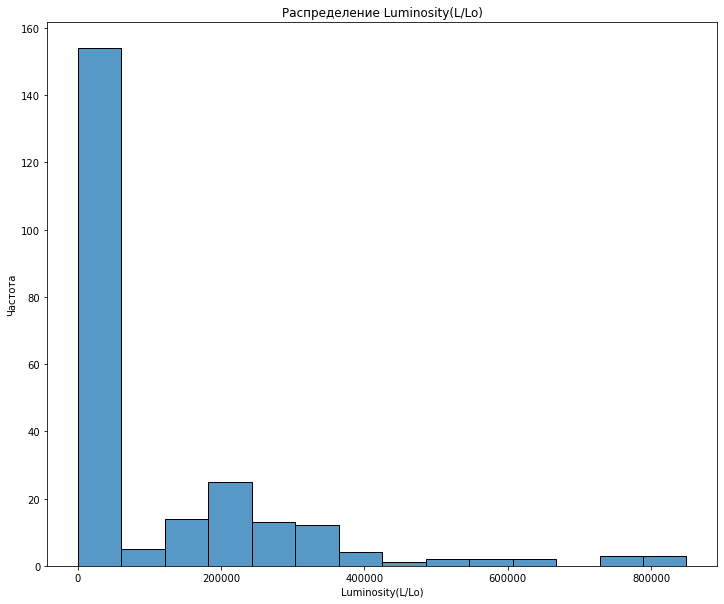

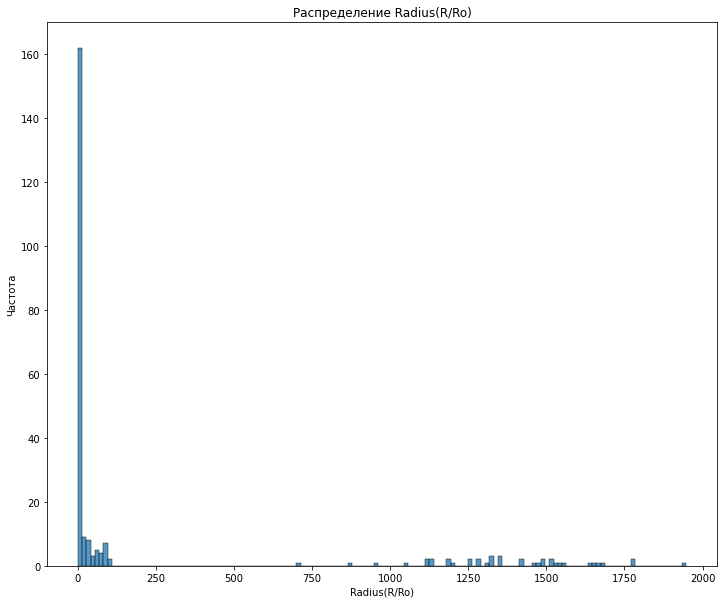

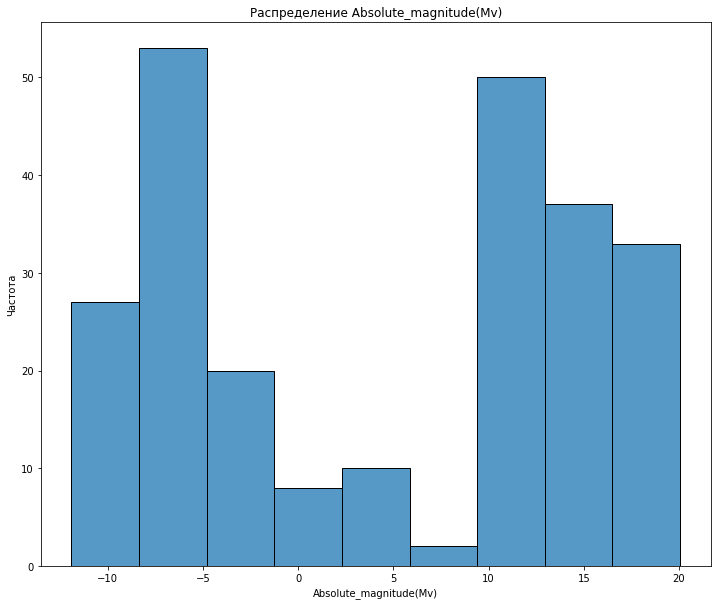

In [8]:
for column, data in df.drop(['Star_color', 'Star_type'], axis=1).items():
    plt.figure(figsize=(12, 10))
    sns.histplot(data=data)
    plt.ylabel('Частота')
    plt.title(f'Распределение {column}')

Взглянув на графики, можно увидеть, что появляются неясности по некоторым признакам, таким как радиус и светимость. Очень много значений около 0, но также есть невероятно большие значения светимости и просто большие значения в радиусе, нужно глянуть boxplot.

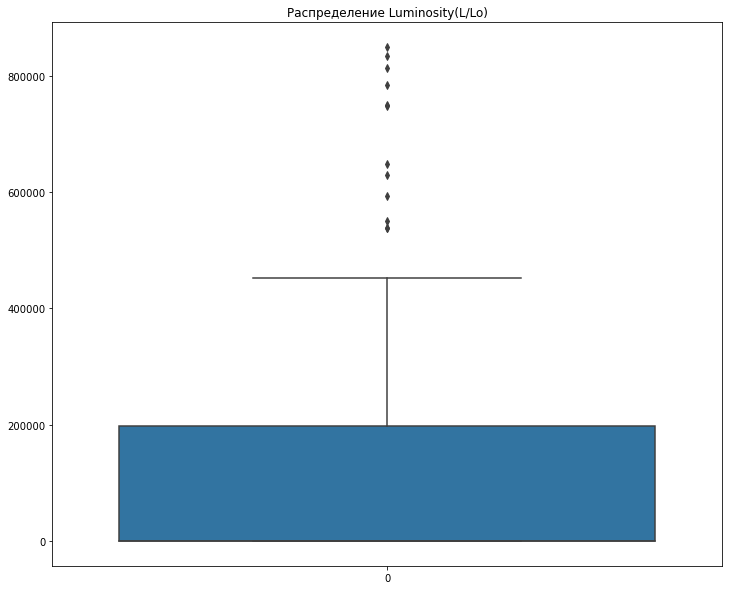

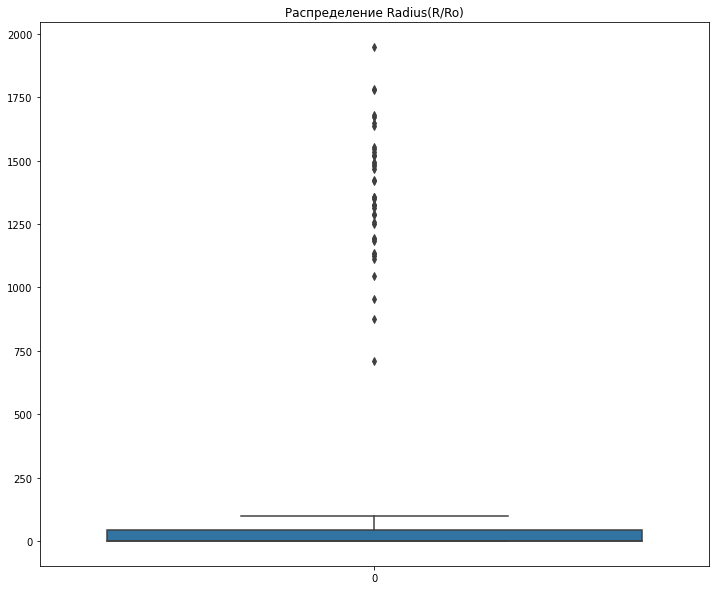

In [9]:
for column, data in df[['Luminosity(L/Lo)', 'Radius(R/Ro)']].items():
    plt.figure(figsize=(12, 10))
    sns.boxplot(data=data, )
    plt.title(f'Распределение {column}')

Есть звезды, у которых очень большая температура, не считаю их выбросами

In [10]:
df.duplicated().sum()

0

In [11]:
df.columns

Index(['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute_magnitude(Mv)', 'Star_type', 'Star_color'],
      dtype='object')

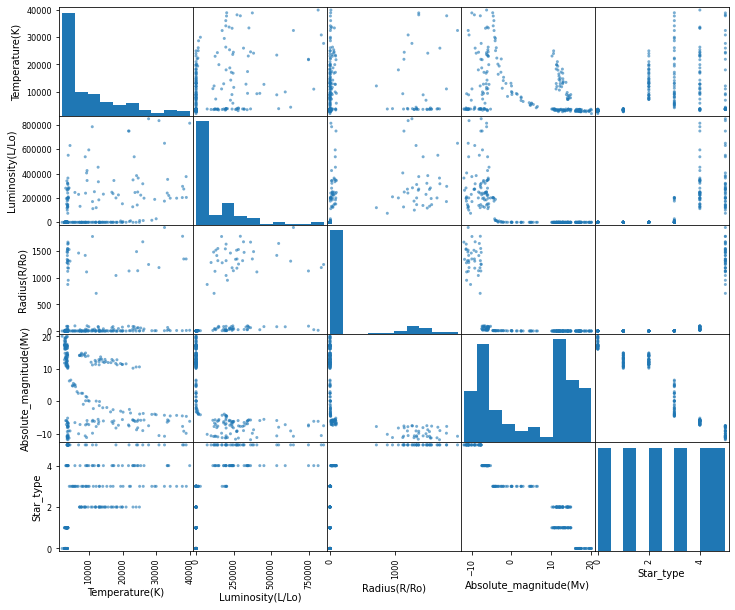

In [12]:
pd.plotting.scatter_matrix(df, alpha=0.6, figsize=(12, 10));

По графикам можно сказать, что температура имеет некие линейные зависимости с остальными признаками, что хорошо. Также есть признаки, которые имеют линейную зависимость между собой.

In [13]:
def rename_color(df, index):
    if df in index:
        return 'other'
    return df

df_corr = df.copy()

df_corr['Star_color'] = df_corr['Star_color'].apply(lambda x: '-'.join(x.lower().split()))
index_color_corr = df_corr['Star_color'].value_counts().tail(9).index

    
df_corr['Star_color'] = df_corr['Star_color'].apply(rename_color, index = index_color_corr)

In [14]:
encoder = LabelEncoder()
df_corr['Star_color'] = encoder.fit_transform(df_corr['Star_color'])

In [15]:
c = df_corr.drop(['Star_color', 'Star_type'], axis=1).corr(method='spearman')

In [16]:
c

,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute_magnitude(Mv)
Temperature(K),1.000000,0.483548,0.253078,-0.520127
Luminosity(L/Lo),0.483548,1.000000,0.890079,-0.890886
Radius(R/Ro),0.253078,0.890079,1.000000,-0.866735
Absolute_magnitude(Mv),-0.520127,-0.890886,-0.866735,1.000000


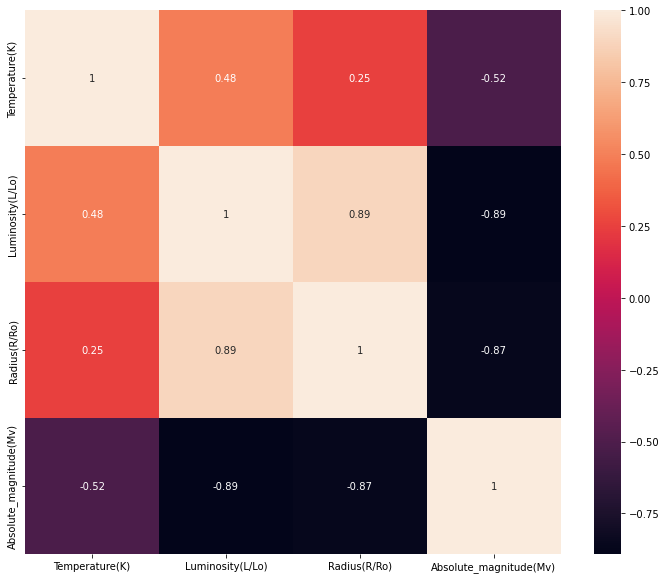

In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.drop(['Star_color', 'Star_type'], axis=1).corr(method='spearman'), annot=True);

Имеются очень сильные зависимости между некоторыми признаками.

In [18]:
def cramers_v(x:float, y:int) -> float:
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))



corr = {'Luminosity(L/Lo)': [cramers_v(df_corr['Luminosity(L/Lo)'], df_corr['Star_type']), 
                             cramers_v(df_corr['Luminosity(L/Lo)'], df_corr['Star_color'])], 
        'Radius(R/Ro)': [cramers_v(df_corr['Radius(R/Ro)'], df_corr['Star_type']), 
                         cramers_v(df_corr['Radius(R/Ro)'], df_corr['Star_color'])], 
        'Absolute magnitude(Mv)': [cramers_v(df_corr['Absolute_magnitude(Mv)'], df_corr['Star_type']), 
                                   cramers_v(df_corr['Absolute_magnitude(Mv)'], df_corr['Star_color'])],
        'Temperature (K)': [cramers_v(df_corr['Temperature(K)'], df_corr['Star_type']), 
                            cramers_v(df_corr['Temperature(K)'], df_corr['Star_color'])]}

df_corr_cat = pd.DataFrame(corr, index=['Star_type', 'Star_color'])

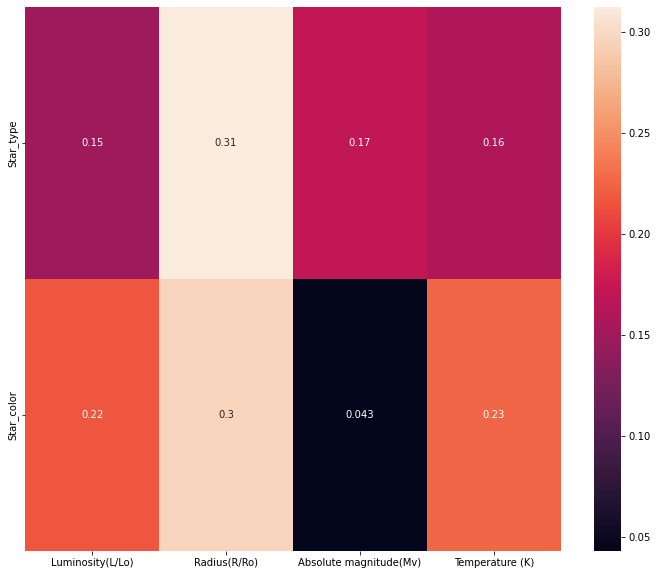

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr_cat, annot=True);

Не такие большие зависимости имеются по некоторым из количественных и категориальных признаков

In [20]:
def initial_charts(column:str):
    plt.figure(figsize=(10, 8))
    sns.histplot(df[column])
    plt.ylabel('Частота');
    
    for c in df_corr.drop(column, axis=1).columns:
        plt.figure(figsize=(12, 10))
        sns.regplot(data=df_corr, x=df_corr[c], y=df_corr[column], color='green')

    plt.figure(figsize=(12, 10))    
    sns.violinplot(df[column]);

### Luminosity(L/Lo)

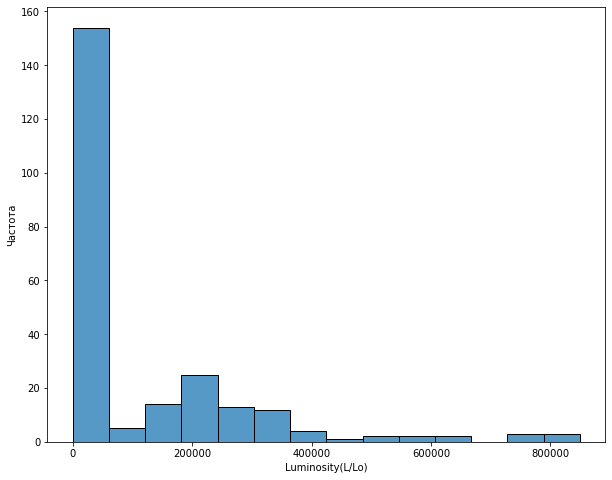

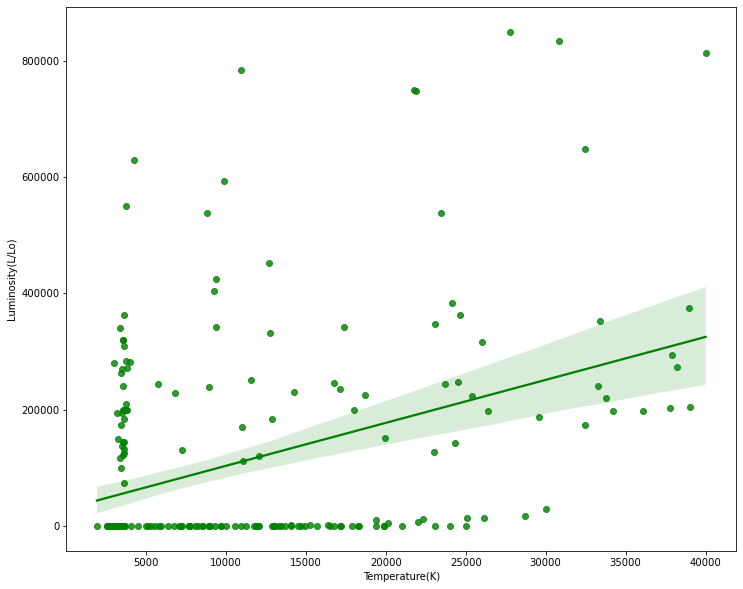

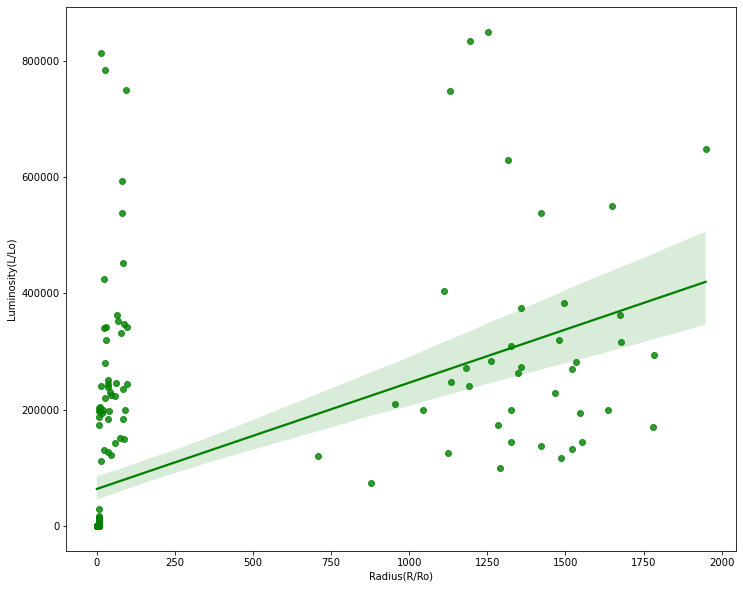

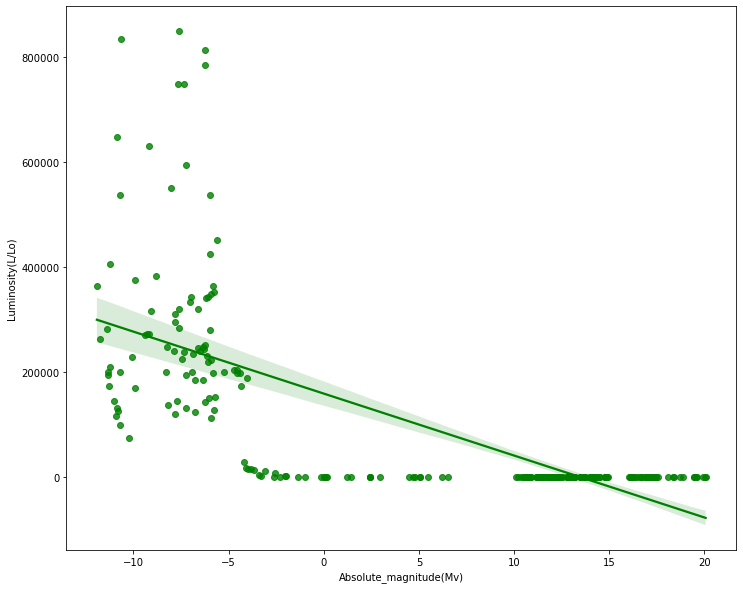

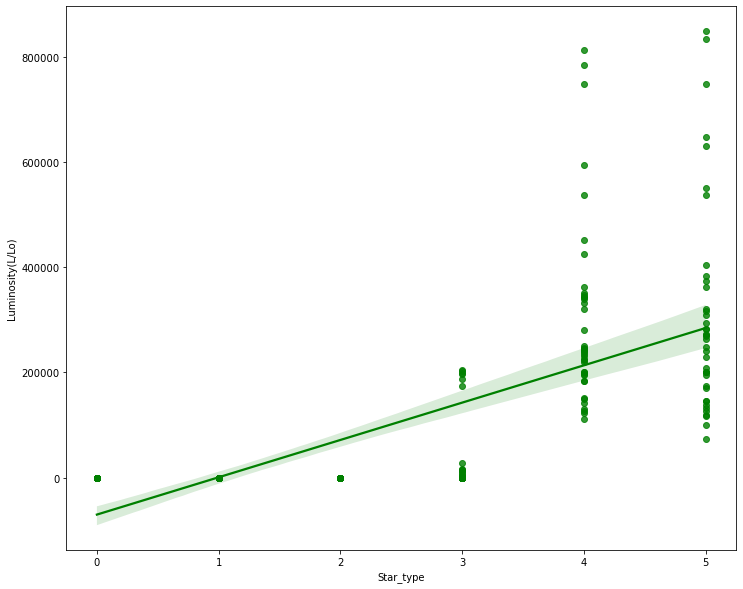

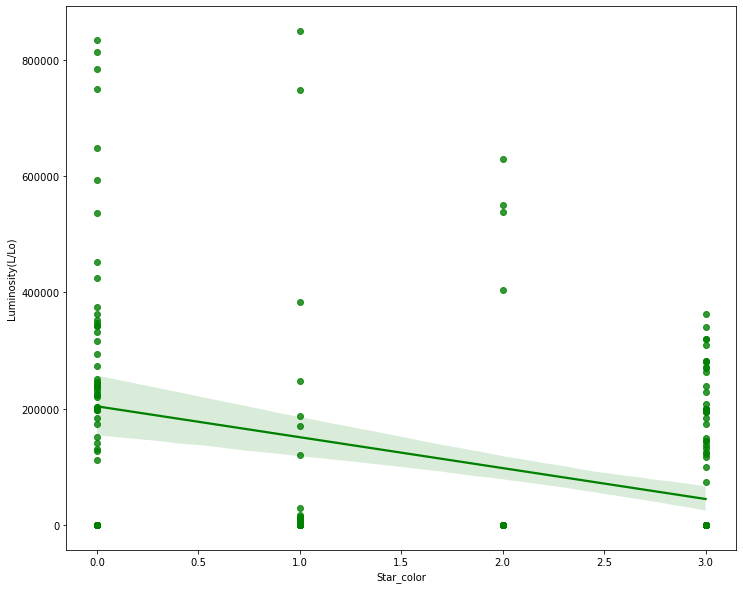

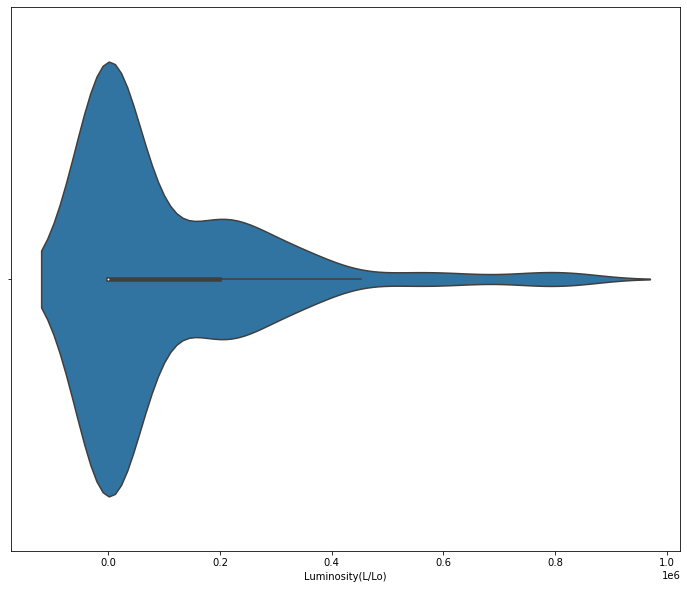

In [21]:
initial_charts('Luminosity(L/Lo)')

**Выводы:**
Распределение у нас ненормальное, есть линейные зависимости с другими признаками, также имеются выбросы, самая большая частота всречи значений в диапазоне 0 - 450000(около 0 самая большая частота встречи)

In [22]:
df[df['Luminosity(L/Lo)'] < 100]['Star_type'].value_counts()

0    40
1    40
2    40
3    17
Name: Star_type, dtype: int64

Те планеты, которые имеют маленькую светимость и маленький радиус - коричневый карлик, красный карлик, белый карлик, звезды главной последовательности.

Ниже нашёл данные, совпадает все.

Коричневые карлики имеют очень низкие светимости и температуры: светимости составляют менее 0,04 L⊙, а обычно — на порядки меньше. Температуры не превышают 2800 K, а у самых холодных коричневых карликов — около 300 K.

Красные карлики также имеют маленькую светимость и температуру около 4000 К.

Белые карлики имеют маленькую светимость, но не нашёл точные цифры.

Основные свойства Cветимости, радиусы и температуры звёзд главной последовательности варьируют в довольно широком диапазоне: встречаются светимости от 10 −4 до 10 6 L⊙ (и абсолютные звёздные величины от −6m до +16m), радиусы — от 0,1 до более чем 10 R⊙, температуры — от 3 до 50 тысяч K.

In [23]:
df[df['Luminosity(L/Lo)'] > 100]['Star_type'].value_counts()

4    40
5    40
3    23
Name: Star_type, dtype: int64

Звезды, которые на графике "выбросы" - здвезды главной последовательности, сверхгиганты, гипергиганты, которые имеют большой радиус, светимость и температуру. Если считать их выбросами и убрать из выборки, то получится так, что потеряем 2 типа звезд...

Итог, оставляем и смотрим дальше

Если удалить эти "выбросы", то потеряется 1 тип звезд и 5 строк из другого типа звезд.

In [24]:
df[(df['Star_type'] == 3) & (df['Luminosity(L/Lo)'] > 100)]

,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute_magnitude(Mv),Star_type,Star_color
30,39000,204000.0,10.600,-4.700,3,Blue
31,30000,28840.0,6.300,-4.200,3,Blue-white
32,15276,1136.0,7.200,-1.970,3,Blue-white
95,11250,672.0,6.980,-2.300,3,Blue-white
98,12098,689.0,7.010,0.020,3,Blue-white
99,36108,198000.0,10.200,-4.400,3,Blue
150,29560,188000.0,6.020,-4.010,3,Blue-white
152,14060,1092.0,5.745,-2.040,3,Blue-white
153,16390,1278.0,5.680,-3.320,3,Blue-white
154,25070,14500.0,5.920,-3.980,3,Blue-white


На счет звезд главной последовательности совпадает, радиус до 10м. А еще подметить можно, что это звезды голубого и голубовато-белые звезды.

### Radius(R/Ro)

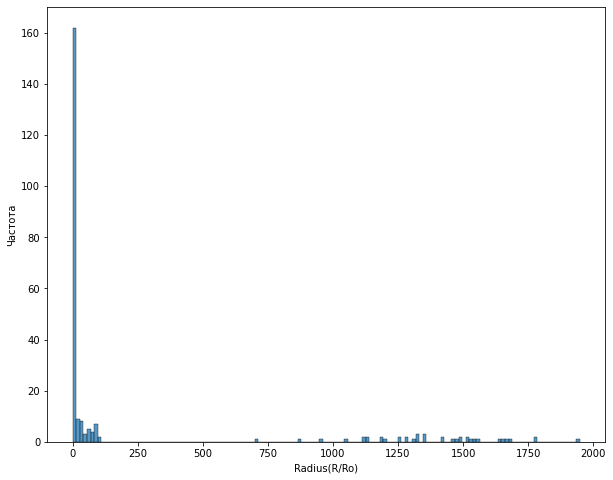

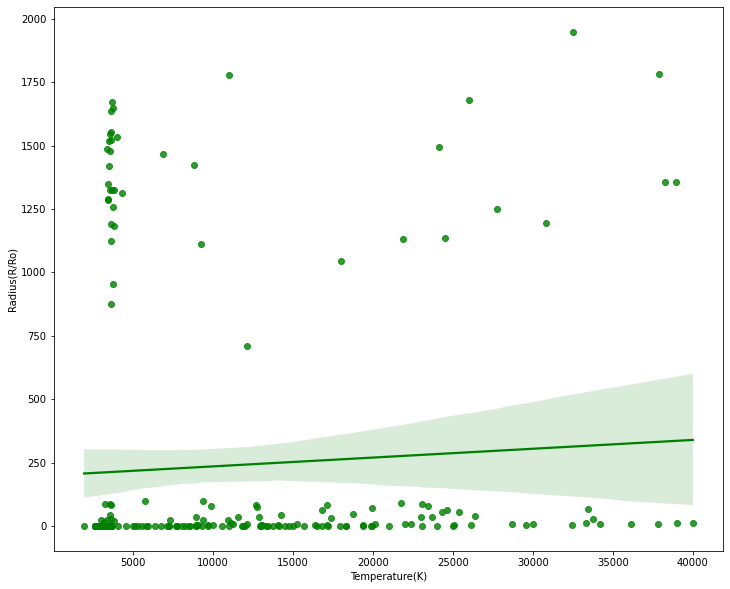

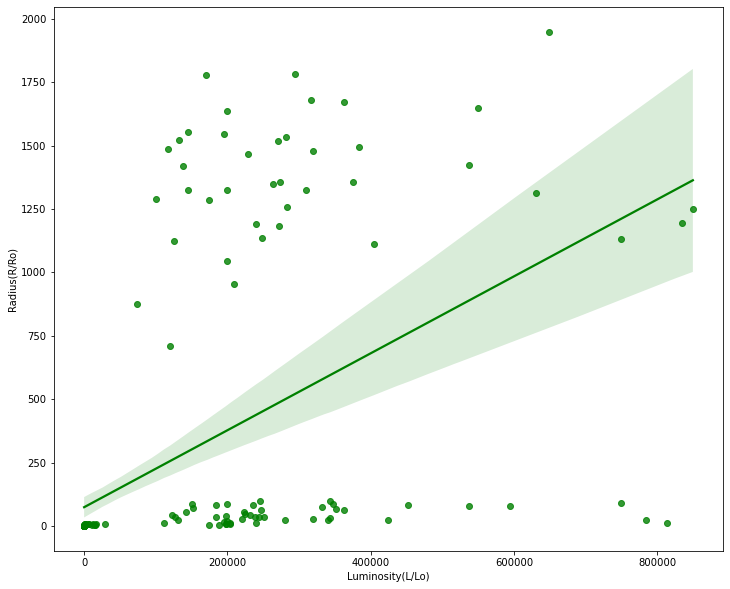

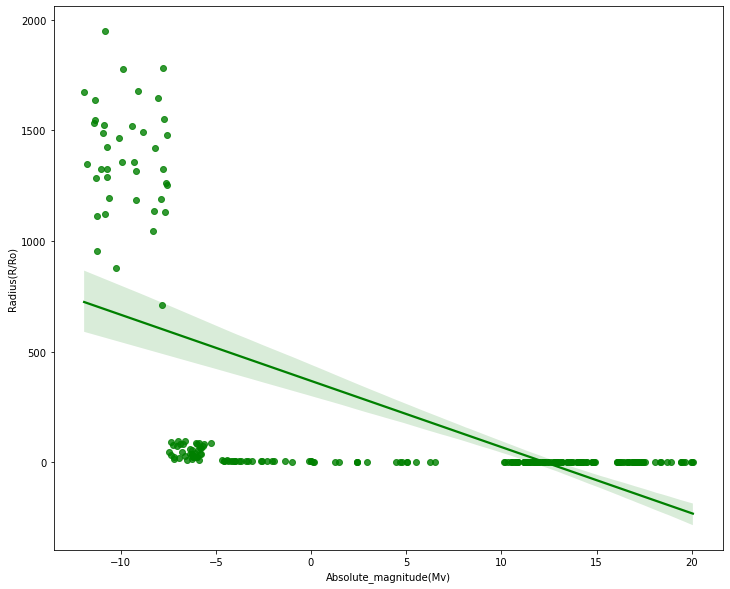

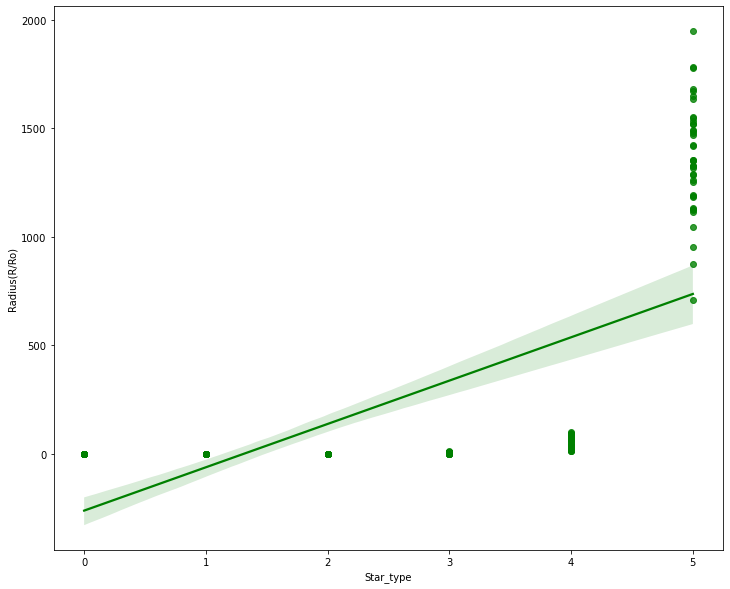

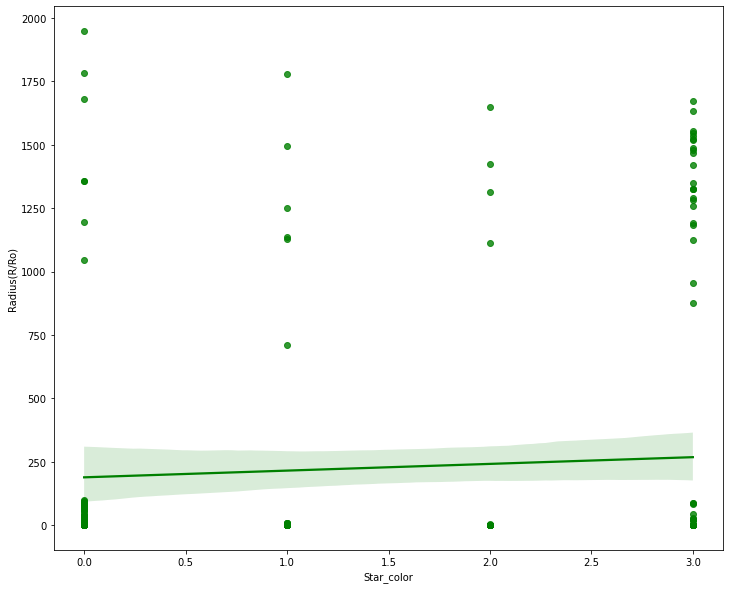

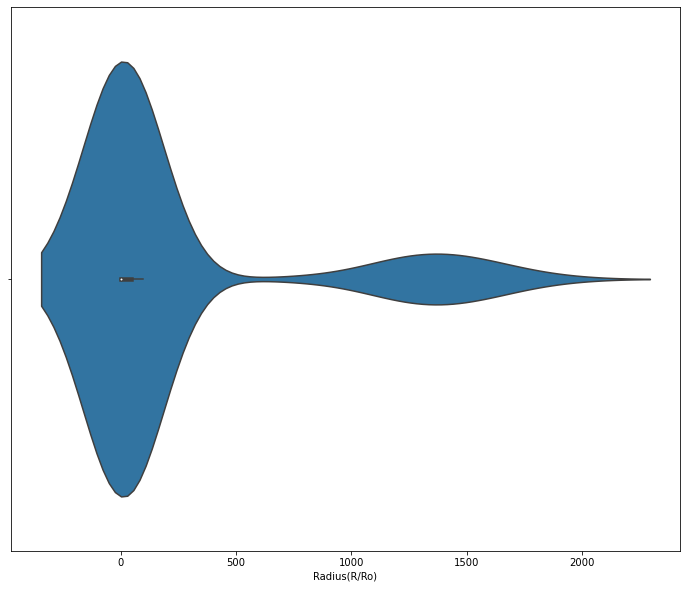

In [25]:
initial_charts('Radius(R/Ro)')

In [26]:
df[df['Radius(R/Ro)'] > 500].shape

(40, 6)

**Выводы**:
Расппределение ненормальное, имеются линейные зависимости между другими признаками, а также выбросы(под ворпосом). Идет просадка между значениями 500-100, после чего начинают встречаться высокие значения, не так уж и мало(17 процентов данных). Выбросы, либо же просто в данных нет звезд с радиусом в этом диапазоне?

### Absolute_magnitude(Mv)

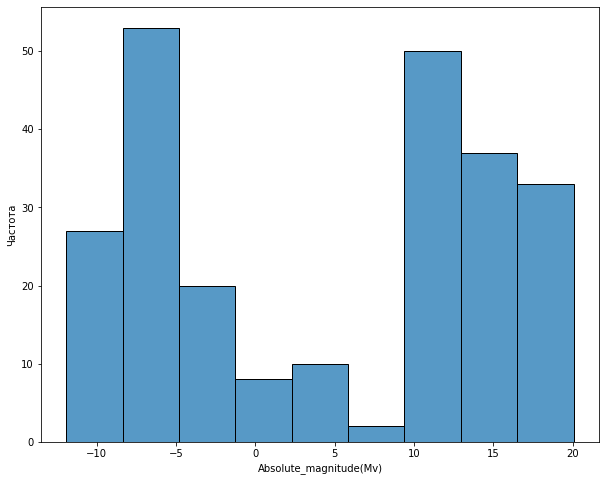

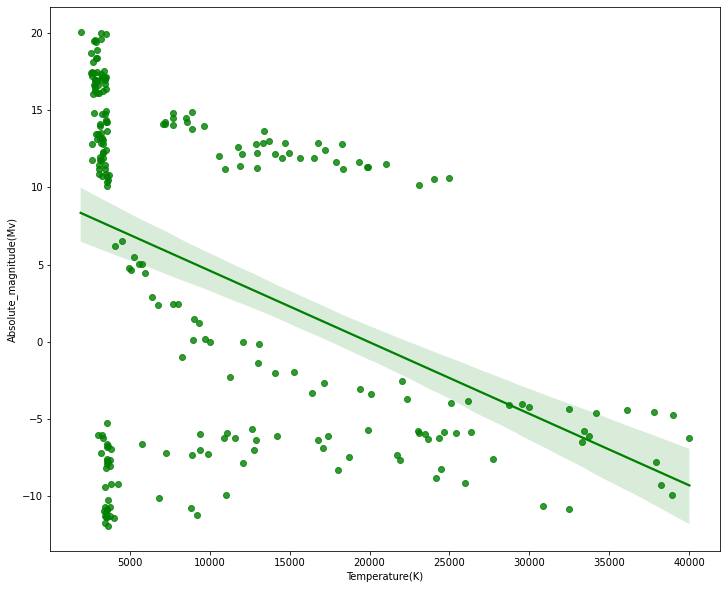

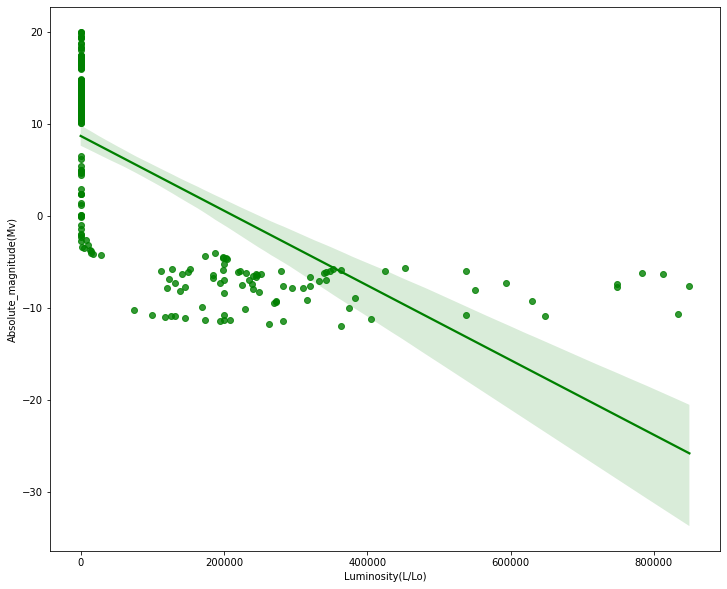

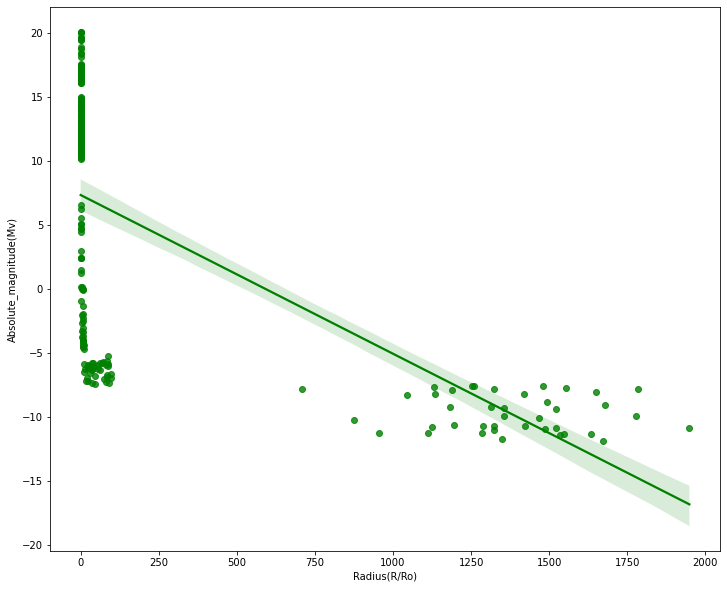

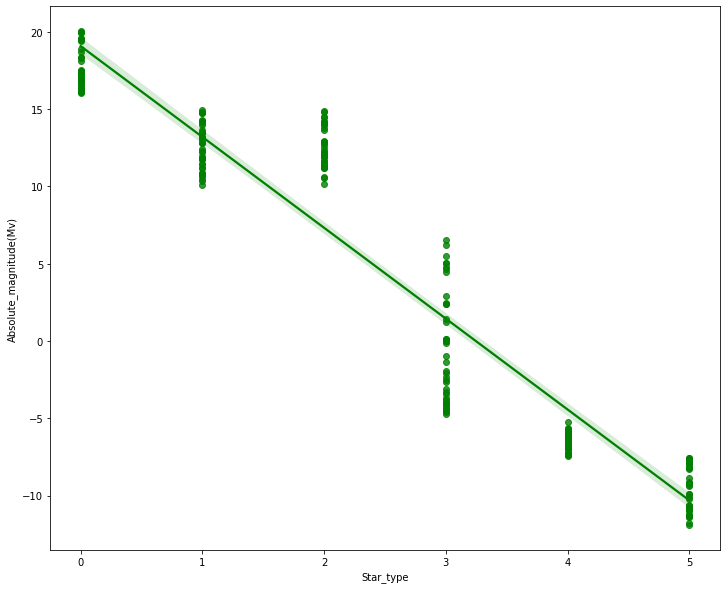

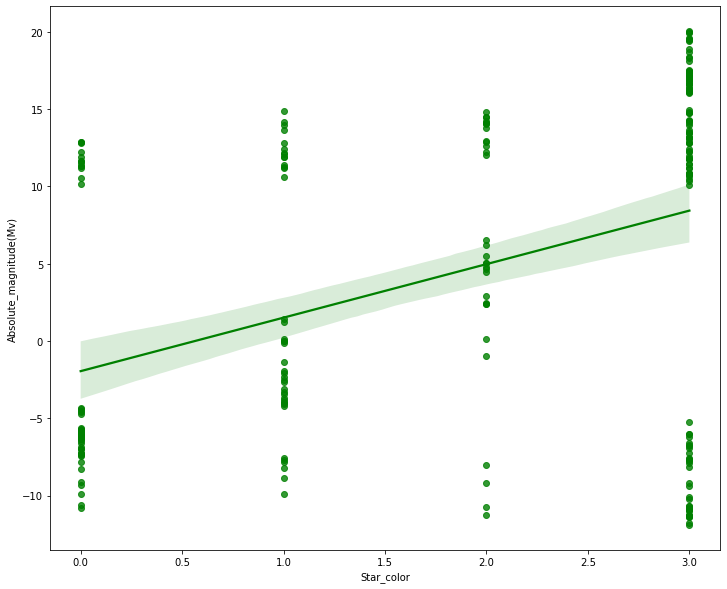

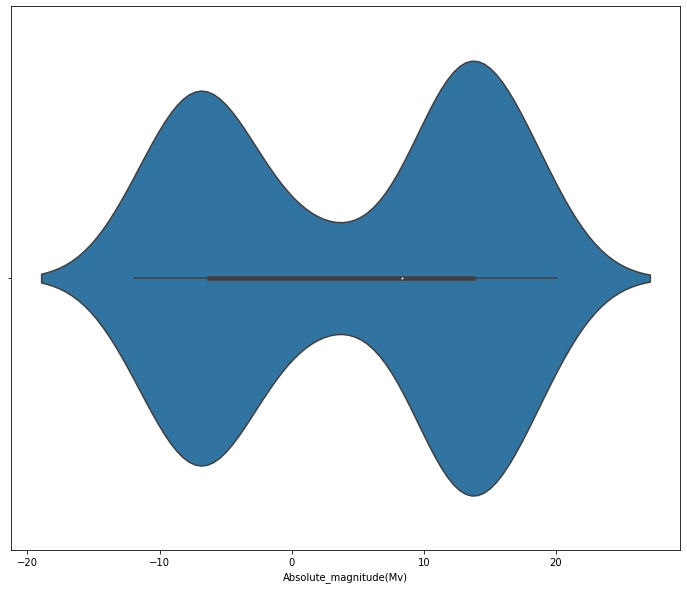

In [27]:
initial_charts('Absolute_magnitude(Mv)')

**Выводы**:
Расппределение ненормальное, но и не пуассоновское, имеются линейные зависимости между другими признаками, выбросы не имеются.

### Star color

In [28]:
df['Star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: Star_color, dtype: int64

In [29]:
df['Star_color'] = df['Star_color'].apply(lambda x: '-'.join(x.lower().split()))

In [30]:
df['Star_color'].value_counts()

red                   112
blue                   56
blue-white             41
white                  10
yellow-white            8
yellowish-white         3
yellowish               3
whitish                 2
orange                  2
pale-yellow-orange      1
white-yellow            1
orange-red              1
Name: Star_color, dtype: int64

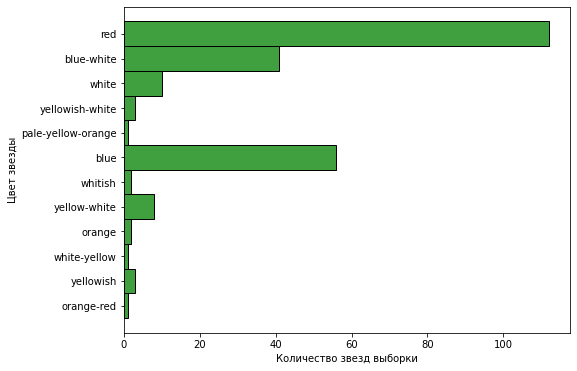

In [31]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, y="Star_color", color='green');
plt.ylabel('Цвет звезды');
plt.xlabel('Количество звезд выборки');

Распределение ненормальное. Чтобы как-то сделать данные пригодными, собираюсь переименовать те звезды, которых мало, в единый цвет - 'other'

In [32]:
index_color = df['Star_color'].value_counts().tail(9).index
df.query('Star_color in @index_color')

,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute_magnitude(Mv),Star_type,Star_color
21,7740,0.000490,0.01234,14.020,2,white
22,7220,0.000170,0.01100,14.230,2,white
23,8500,0.000500,0.01000,14.500,2,white
25,12990,0.000085,0.00984,12.230,2,yellowish-white
27,7700,0.000110,0.01280,14.470,2,yellowish-white
28,11790,0.000150,0.01100,12.590,2,yellowish-white
29,7230,0.000080,0.01300,14.080,2,pale-yellow-orange
33,9700,74.000000,2.89000,0.160,3,whitish
34,5800,0.810000,0.90000,5.050,3,yellow-white
35,8052,8.700000,1.80000,2.420,3,whitish


In [33]:
df['Star_color'] = df['Star_color'].apply(rename_color, index=index_color)

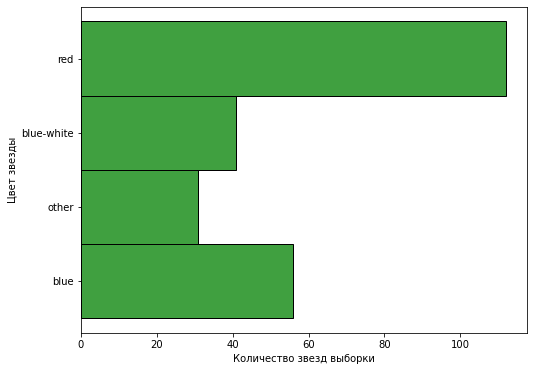

In [34]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, y="Star_color", color='green');
plt.ylabel('Цвет звезды');
plt.xlabel('Количество звезд выборки');

In [35]:
df['Star_color'].value_counts()

red           112
blue           56
blue-white     41
other          31
Name: Star_color, dtype: int64

Получили распределение лучше, чем оно было

**Основной вывод**

Имеется мультиколлениарность, от которой желательно избавиться, т.е. это может быть из-за того, что признаки посчитаны относительно Солнца и из-за этого может происходить эта зависимость, что нужно будет проверить. 
Также признаки неплохо зависимы с таргетом, что хорошо для линейных моделей. 
Буду провобовать убирать мультиколлениарность, приводить распределения к нормальному с помощью логарифмирования.

---

## Построение базовой нейронной сети

Что собираюсь делать? Собираюсь удалить один из признаков, который присутствует в формулах других признаков, чтобы попробовать избежать мультиколлинеарности. Также буду использовать 3 выборки и кросс валидацию.

In [36]:
df = df.drop(['Luminosity(L/Lo)'], axis=1)

In [37]:
features = df.drop('Temperature(K)', axis=1)
target = df['Temperature(K)']

In [38]:
ohe = OneHotEncoder(drop='first')
ohe_df = ohe.fit_transform(np.array(features['Star_color']).reshape(-1, 1))
ohe_df = pd.DataFrame(ohe_df.todense(), columns=ohe.get_feature_names('c'))

In [39]:
features = features[['Radius(R/Ro)', 'Absolute_magnitude(Mv)', 'Star_type']].join(ohe_df)

In [40]:
features.head()

,Radius(R/Ro),Absolute_magnitude(Mv),Star_type,c_blue-white,c_other,c_red
0,0.1700,16.12,0,0.0,0.0,1.0
1,0.1542,16.60,0,0.0,0.0,1.0
2,0.1020,18.70,0,0.0,0.0,1.0
3,0.1600,16.65,0,0.0,0.0,1.0
4,0.1030,20.06,0,0.0,0.0,1.0


In [41]:
x_train, x_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state=67)


x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.5, random_state=67)

# для кросс валидации 
x_train_cv, x_test_cv, y_train_cv, y_test_cv = train_test_split(features, target, test_size=0.2, random_state=67)


Разделили данные на 80, 10, 10

In [42]:
scaler = StandardScaler()
numeric = ['Absolute_magnitude(Mv)', 'Radius(R/Ro)']
x_train[numeric] = scaler.fit_transform(x_train[numeric])
x_valid[numeric] = scaler.transform(x_valid[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])



scaler_cv = StandardScaler()
x_train_cv[numeric] = scaler_cv.fit_transform(x_train_cv[numeric])
x_test_cv[numeric] = scaler_cv.transform(x_test_cv[numeric])


In [43]:
x_train

,Radius(R/Ro),Absolute_magnitude(Mv),Star_type,c_blue-white,c_other,c_red
237,2.206453,-1.383915,5,0.0,1.0,0.0
17,-0.468227,0.645707,1,0.0,0.0,1.0
10,-0.468152,0.635338,1,0.0,0.0,1.0
107,-0.401423,-0.970072,4,0.0,0.0,0.0
75,-0.468453,0.736206,1,0.0,0.0,1.0
...,...,...,...,...,...,...
7,-0.468930,1.267886,0,0.0,0.0,1.0
197,-0.468479,1.035983,1,0.0,0.0,1.0
202,-0.469089,0.780513,2,0.0,0.0,0.0
53,2.629504,-1.131273,5,0.0,1.0,0.0


In [44]:
x_train.shape[0], x_valid.shape[0], x_test.shape[0]

(192, 24, 24)

In [45]:
# для целой выборки
x_train_tensor = torch.Tensor(x_train.values)
x_valid_tensor = torch.Tensor(x_valid.values)
x_test_tensor = torch.Tensor(x_test.values)
y_train_tensor = torch.Tensor(y_train.values)
y_valid_tensor = torch.Tensor(y_valid.values)
y_test_tensor = torch.Tensor(y_test.values)


# для кросс валидации
x_train_tensor_cv = torch.Tensor(x_train_cv.values)
x_test_tensor_cv = torch.Tensor(x_test_cv.values)
y_train_tensor_cv = torch.Tensor(y_train_cv.values)
y_test_tensor_cv = torch.Tensor(y_test_cv.values)



---

### BASELINE

In [78]:
class NetNeuralTwoRelu(nn.Module):
    def __init__(self, n_hidden_neurons_1, n_hidden_neurons_2):
        super(NetNeuralTwoRelu, self).__init__()
        
        self.fc1 = nn.Linear(6, n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x     

net = NetNeuralTwoRelu(1250, 1000)

Получилось так, что для выборки с удалением строк оказались лучшие функции активации - Tanh/ReLU, а для целой выборки - 2ReLU

In [73]:
mean_squared_error(y_test_tensor, net.forward(x_test_tensor).flatten().detach().numpy(), squared=False)

16611.344

**Вывод по BASELINE**


Модели имеют невероятную ошибку, следовательно, они плохо чему обучились. Для обучения нужно использовать градиентный спуск, что я и буду делать дальше.

## Улучшение нейронной сети

In [71]:
# функции обучения и графика
def train_model(x_train, y_train, x_valid, y_valid, model, n_e=2000, lr=1e-3, l=nn.MSELoss()):
    
    result = {'Epoch': [], 'rmse_train': [], 'rmse_test': []}
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss = l

    num_epochs = n_e

    for epoch in range(num_epochs):

        optimizer.zero_grad()

        preds = model.forward(x_train).flatten()

        loss_value = loss(preds, y_train)
        loss_value.backward()

        optimizer.step()

        model.eval()

        train_preds = model.forward(x_train).flatten().detach().numpy()
        test_preds = model.forward(x_valid).flatten().detach().numpy()
        score_train = mean_squared_error(y_train, train_preds, squared=False)
        score_test = mean_squared_error(y_valid, test_preds, squared=False)

        if epoch == (num_epochs - 1):
            print('|| Epoch: {}  || Loss: {} || RMSE: {} ||'.format(epoch, loss_value, score_test))

        if epoch == (num_epochs - 1):
            print('End!')

        result['Epoch'].append(epoch)
        result['rmse_train'].append(score_train)
        result['rmse_test'].append(score_test)
        
    return result


def graf_result(df):
    plt.figure(figsize=(10, 8), )
    plt.plot(df['rmse_train'])
    plt.plot(df['rmse_test'])
    plt.xlabel('epoh')
    plt.ylabel('rmse')
    plt.grid(True)
    plt.legend(['train', 'valid'])
    plt.show()
    

### Кросс валидация

In [93]:
model_one = NeuralNetRegressor(
            NetNeuralTwoRelu(1250, 1000),
            criterion=nn.MSELoss,
            max_epochs=1400,
            optimizer=torch.optim.Adam,
            optimizer__lr = 1e-3,
            callbacks='disable')


In [94]:
score_valid = cross_val_score(model_one, x_train_tensor_cv, y_train_tensor_cv.reshape(-1, 1), 
                              scoring='neg_root_mean_squared_error', error_score="raise")

In [95]:
score_cv = abs(score_valid.mean())

In [96]:
score_cv

4924.44736328125

### train + valid + test

In [79]:
result_graf_one = train_model(x_train_tensor, y_train_tensor, x_valid_tensor, y_valid_tensor, 
                                net, l=nn.MSELoss(), lr=1e-3, n_e=1400)

|| Epoch: 1399  || Loss: 18617966.0 || RMSE: 1879.744873046875 ||
End!


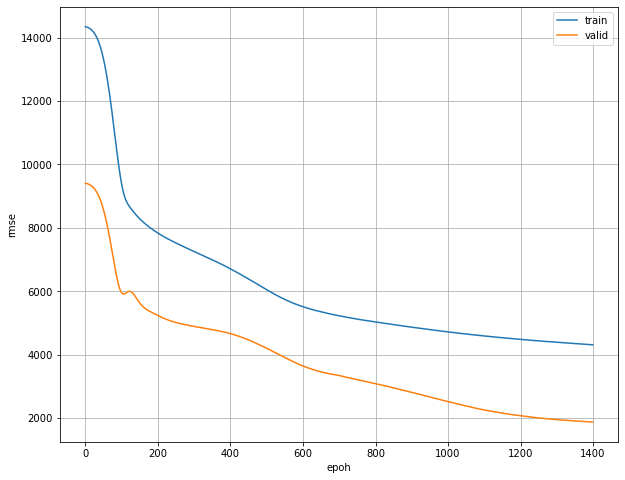

In [80]:
df_result = pd.DataFrame(result_graf_one)
graf_result(df_result)

Видно, что валидационная выборка показывает лучшие результаты по сравнению с трейновой. Связано это с тем, что выборки разделились так, что в валидационную попали звезды, которые имеют низкую температуру, а в трейновую по большей части с высокой температурой

In [81]:
mean_squared_error(y_test_tensor, net.forward(x_test_tensor).detach().numpy(), squared=False)

4004.3118

В тестовую выборку попали все типы звезд и в итоге получается так, что rmse показан по всем температурам звезд.

## Выводы

In [82]:
pred_full = pd.Series([i[0] for i in net.forward(x_test_tensor).detach().numpy()])

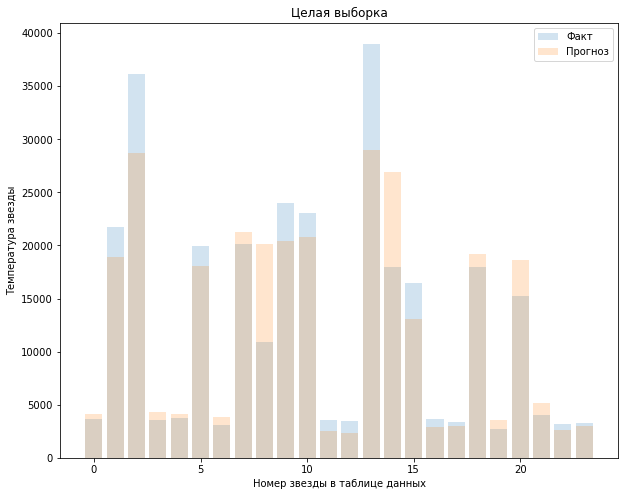

In [83]:
plt.figure(figsize=(10, 8))
plt.bar(y_test.reset_index(drop=True).index, height=y_test, alpha=0.2);
plt.bar(pred_full.index, height=pred_full, alpha=0.2);
plt.legend(['Факт', 'Прогноз'])
plt.xlabel('Номер звезды в таблице данных');
plt.ylabel('Температура звезды');
plt.title('Целая выборка')
plt.show()

In [85]:
mean_squared_error(y_test_tensor, net.forward(x_test_tensor).detach().numpy(), squared=False)

4004.3118

Звезды с маленькой температурой предсказываются очень хорошо, а с высокой температурой с большой погрешностью

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод <a class="tocSkip"> </h2>
Итоговые результаты: кросс валидация - 4924, test - 4004
    